In [5]:
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth, col_binned
from data_handling import data_load as dl
from data_handling.data_load import get_warping_parameters
from analysis import stimulus as st
from analysis import response_functions as rf


#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
uf = dl.list_cells(cells_path)
all_cells = [f for f in uf if f.find('KPawakeM72_019')>-1]
print all_cells
all_records = dl.load_cells(cells_path, all_cells)

#all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )

#get the first response and plot it
warp = True
#st_1.responses['ZKawakeM72_013_e_010'].get_response_onset(warped=warp)
#rp = st_1.responses['ZKawakeM72_013_e_010'].plot(warped=warp)

#make all the odor stimuli
tags = {'light':1}
# {odor_name: [stim_aliases], conc, records, tags, extra_plot_pars}

all_odors_list = {'2-hydroxy_high': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051, 
                  all_records, tags, {'color': '#9F000F', 'alpha': 1.}],
                  
                  '2-hydroxy_med': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 2.97e-4,
                                    all_records, tags, {'color': '#F62217', 'alpha': .5}],
                  
                  '2-hydroxy_low': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 1.8e-5,
                                    all_records, tags, {'color': '#E77471', 'alpha': .25}],
                  
                  'ethyl_tiglate': [['ethyl_tiglate','ethyltiglate'], 1.3e-4,
                                    all_records, tags, {'color': '#41a317', 'alpha': 1.}],
                  
                  'acetophenone': [['acetophenone','acetoph'], 7.9e-4, 
                                   all_records, tags, {'color': '#43c6db', 'alpha': 1.}],
                  
                  '4-methyl': [['4-methylacetophenone','4methyl'], 1.8e-3,
                               all_records, tags, {'color': '#FF00FF', 'alpha': 1.}],
                  
                  'benzaldehyde': [['benzaldehyde', 'benz'], 1.9e-4,
                                   all_records, tags, {'color': '#F88017', 'alpha': 1.}],
                  
                  '2-4-dimethyl': [['2-4-dimethylacetophenone', '24-dimethylacetophenone'], 5.8e-3, 
                                   all_records, tags, {'color': '#FFD801', 'alpha': 1.}],
                  
                  'menthone_high': [['menthone', 'mentone'], 1.6e-2,
                                    all_records,tags, {'color': '#000080', 'alpha': 1.}],
                  
                  'menthone_med': [['menthone', 'mentone'], 1.6e-3,
                                   all_records, tags, {'color': '#1569c7', 'alpha': 0.5}],
                  
                  'menthone_low': [['menthone', 'mentone'], 7e-5,
                                   all_records, tags, {'color': '#188AC7', 'alpha': .25}]
                 }
all_odors = {}
for key, sd in all_odors_list.iteritems():
    all_odors.update({key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags=sd[3], extra_plot_pars=sd[4])})

print all_odors.keys()
#[r.plot(warped=True) for r in list(st_1.responses.values())]

Computer: server
['KPawakeM72_019_002', 'KPawakeM72_019_003', 'KPawakeM72_019_004', 'KPawakeM72_019_005', 'KPawakeM72_019_006', 'KPawakeM72_019_007', 'KPawakeM72_019_010', 'KPawakeM72_019_011', 'KPawakeM72_019_013', 'KPawakeM72_019_014', 'KPawakeM72_019_015', 'KPawakeM72_019_018', 'KPawakeM72_019_020', 'KPawakeM72_019_021']
/experiment/export_data/data_play/KPawakeM72_019_002_cell.mat
['KPawakeM72_019_d_002', 'KPawakeM72_019_b_002']
/experiment/export_data/data_play/KPawakeM72_019_003_cell.mat
['KPawakeM72_019_b_003']
/experiment/export_data/data_play/KPawakeM72_019_004_cell.mat
['KPawakeM72_019_b_004']
/experiment/export_data/data_play/KPawakeM72_019_005_cell.mat
['KPawakeM72_019_b_005']
/experiment/export_data/data_play/KPawakeM72_019_006_cell.mat
['KPawakeM72_019_b_006']
/experiment/export_data/data_play/KPawakeM72_019_007_cell.mat
['KPawakeM72_019_a_007', 'KPawakeM72_019_d_007', 'KPawakeM72_019_b_007']
/experiment/export_data/data_play/KPawakeM72_019_010_cell.mat
['KPawakeM72_019_d

In [73]:
from IPython import parallel
clients = parallel.Client(profile='default')
clients.block = True
print clients.ids
view = clients.load_balanced_view()

[0, 1, 2, 3, 4, 5, 6]


In [80]:
#compute involved observables on each loaded response
def compute_onset(r):
    
    comp_name=socket.gethostname()
    if  comp_name == 'Ezequiels-MacBook-Pro.local':
        print 'Computer: ' + comp_name
        sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
        experiment_folder = os.path.join('/Users','zeke','experiment')
    else:
        print 'Computer: ' + 'server'
        sys.path.append('/experiment/ephysDataManagement/ephysScripts')
        experiment_folder = os.path.join('/','experiment')
    
    from data_handling.basic_plot import decim, plot_raster, make_psth, col_binned
    from data_handling import data_load as dl
    from data_handling.data_load import get_warping_parameters
    from analysis import stimulus as st
    from analysis import response_functions as rf
    import analysis
    
    warp = False
    bin_size = 15
    p=0.05
    print "getting onset for" + r.rec['rec_id']
    r.get_response_onset(warped=warp, bin_size=bin_size, p_ks=p)
    return r.response_onset['onset']


responses = [r for r in list(s.responses.values()) for s in list(all_odors.values())]
#lbv.map(compute_onset, [0, 1, 2, 3])
view.map(compute_onset, responses[0:7])

CompositeError: one or more exceptions from call to method: compute_onset
[0:apply]: ImportError: No module named analysis.stimulus
[5:apply]: ImportError: No module named analysis.stimulus
[4:apply]: ImportError: No module named analysis.stimulus
[2:apply]: ImportError: No module named analysis.stimulus
.... 3 more exceptions ...

[('', '', 0.0, 0.0, 0.0, 0.0, 0.0)]
ethyl_tiglate
[]
4-methyl
[]
menthone_med
['KPawakeM72_019_d_002', 'KPawakeM72_019_b_002']
menthone_high
['KPawakeM72_019_b_002']
acetophenone
[]
2-4-dimethyl
[]
menthone_low
['KPawakeM72_019_b_002']
2-hydroxy_med
['KPawakeM72_019_d_002']
2-hydroxy_high
['KPawakeM72_019_d_002', 'KPawakeM72_019_b_002']
2-hydroxy_low
[]
benzaldehyde
[]


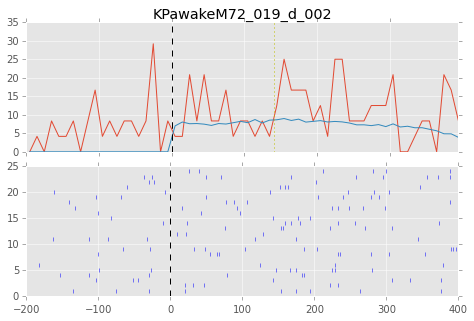

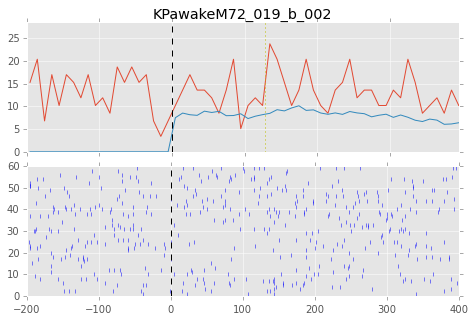

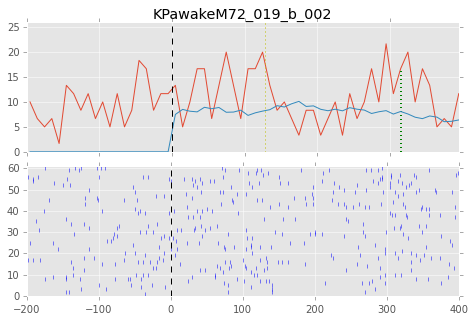

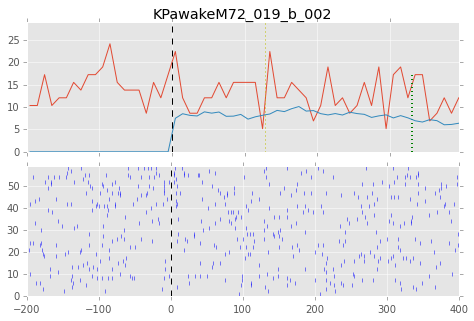

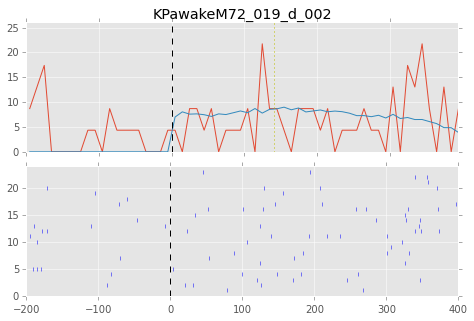

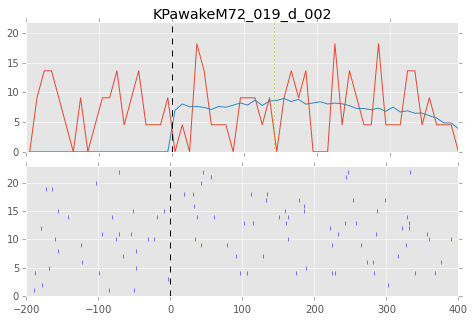

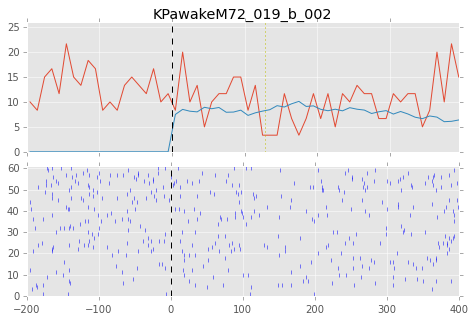

In [4]:
#plot all the responses to all the stimuli
response_row = np.zeros(1, dtype=[('stim', '|S32'), ('resp', '|S32'), ('latency', 'f4'), ('onset_lvl','f4'), 
                                  ('spikes_inh', 'f4'), ('spikes_exh', 'f4'), ('spikes', 'f4')]) 
litrals = np.zeros_like(response_row)
print litrals
warp = False
bin_size = 15
p=0.05
for st_name, stim in all_odors.iteritems():
    print st_name
    print stim.responses.keys()
    for r_name, r in list(stim.responses.iteritems()):
        this_resp = np.zeros_like(response_row)
        this_resp['stim'] = st_name
        this_resp['resp'] = r_name
        r.get_response_onset(warped=warp, bin_size=bin_size, p_ks=p)
        this_resp['latency'] = r.response_onset['onset']
        this_resp['onset_lvl'] = r.response_onset['response'] - r.response_onset['baseline']
        this_resp['spikes_inh'], this_resp['spikes_exh'] = r.get_spike_count()
        this_resp['spikes'] = this_resp['spikes_inh'] + this_resp['spikes_exh']
        litrals = np.append(litrals, this_resp)
        r.plot(warped=warp)
    

(0, 3)

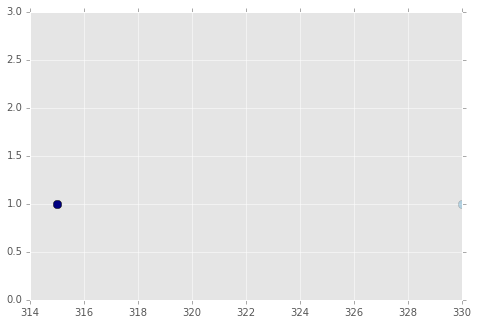

In [6]:
prop = 'spikes_exh'

feature_fig = plt.figure()
ax = feature_fig.add_axes([0, 0, 1, 1])

n_recs = 0
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = 'v'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])

# ax.set_ylim(0, n_recs+1)

# prop = 'spikes_inh'
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = '^'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])
    
prop = 'latency'
for odor, stim in all_odors.iteritems():
    #print odor
    feat = litrals[litrals['stim'] == odor][prop]
    #print feat
    stim.plot_pars['marker'] = 'o'
    stim.plot_pars['ms'] = 8
    ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
    n_recs = max(n_recs, feat.shape[0])

ax.set_ylim(0, n_recs+1)

{'ax_stack': <matplotlib.figure.AxesStack at 0x7fa4476b3110>,
 'fig': None,
 'figure': <matplotlib.figure.Figure at 0x7fa447dc8b50>}

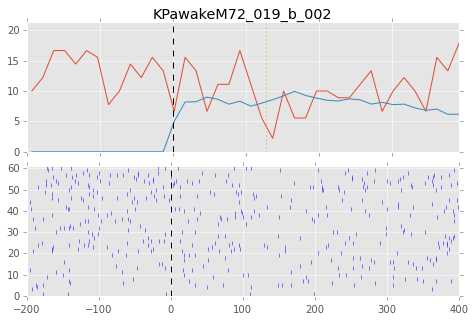

In [23]:
r = all_odors['2-hydroxy_high'].responses['KPawakeM72_019_b_002']
warp = False
bin_size = 15
p=0.05

r.get_response_onset(warped = warp, p_ks=p, bin_size = bin_size)
r.plot(warped=warp, bin_size=bin_size)
#rf.find_onset(r, warped=warp, p=p, bin_size=bin_size, debug=True)


{'onset': 165, 'p': array([ 1.        ,  0.9851339 ,  0.99999999,  1.        ,  1.        ,
        0.55922267,  1.        ,  1.        ,  0.99999993,  1.        ,
        1.        ,  1.        ,  0.9999997 ,  1.        ,  1.        ,
        0.86828046,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99973922,  0.99805101,  1.        ,  1.        ]), 'response': 51.612903225806448, 'supra': True, 'baseline': 19.719909159727479}


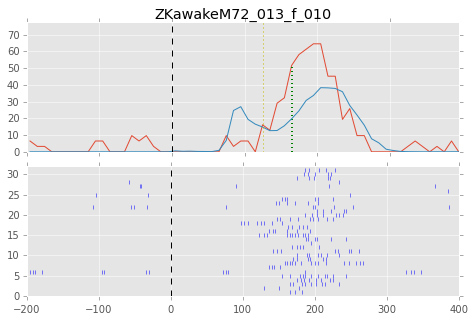

In [9]:
stim = all_odors['2-4-dimethyl']
stim.responses.keys()
warp = False
[r.get_response_onset(warped=warp) for r in list(stim.responses.values())]
[r.plot(warped=warp) for r in list(stim.responses.values())]
print r.response_onset

In [27]:
r.response_onset

{'baseline': 12.320092112838228,
 'onset': 98,
 'p': array([ 1.        ,  1.        ,  1.        ,  0.99999573,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         0.97138676,  1.        ,  1.        ,  1.        ,  1.        ,
         0.99999129,  1.        ,  1.        ,  0.96453389,  0.99998781,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  0.99999573,  1.        ,
         0.97820411,  1.        ,  1.        ,  0.99998968,  1.        ]),
 'response': 31.111111111111111,
 'supra': True}

In [3]:
import itertools
stim = all_odors['ethyl_tiglate']
print stim.responses.keys()
r = stim.responses.values()[1]
p, iss, ks = rf.find_onset(r, warped=warp, p=0.05)
print ks < 0.05
onset = next(itertools.ifilter(lambda i: ks[i] < 0.05, range(len(ks))), None)
print onset

['ZKawakeM72_013_e_011', 'ZKawakeM72_013_e_010']
[False False False False False False False False False False False False
 False False False False False  True False  True  True False False False
 False False False False False False  True  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
17


['ZKawakeM72_013_f_010', 'ZKawakeM72_004_h_001', 'ZKawakeM72_004_i_001', 'ZKawakeM72_004_i_002', 'ZKawakeM72_004_h_002', 'ZKawakeM72_013_e_011', 'ZKawakeM72_013_e_010']
{'onset': 74, 'p': array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.9993188 ,  1.        ,
        1.        ,  1.        ,  0.9993188 ,  0.9993188 ,  1.        ,
        1.        , 

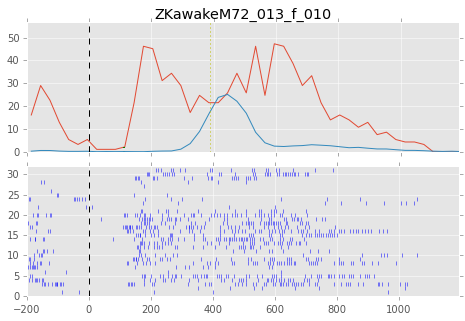

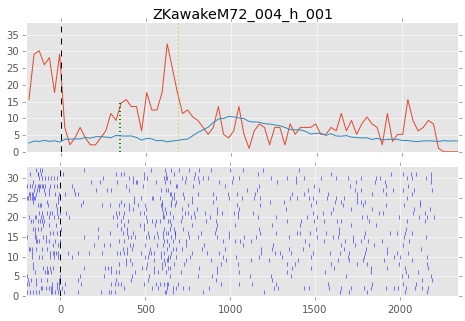

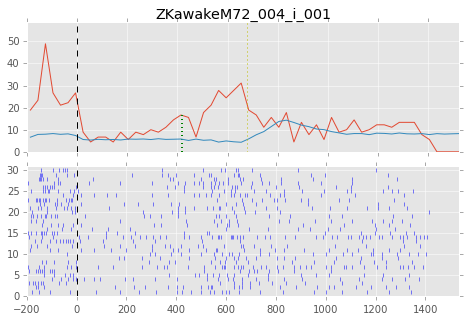

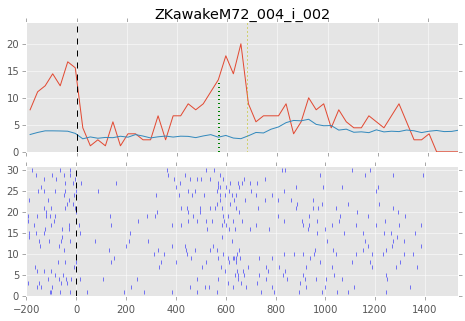

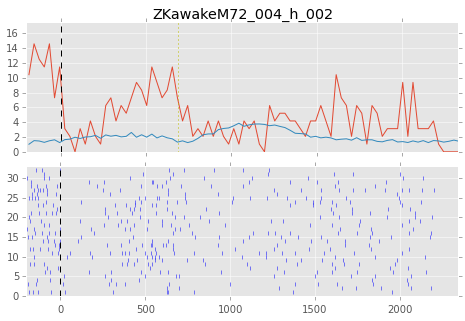

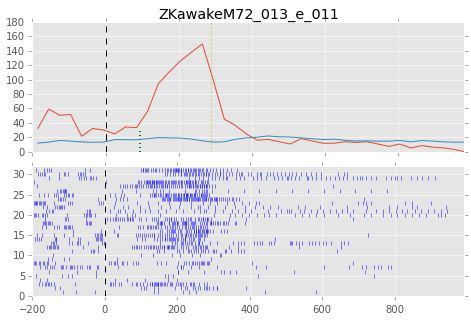

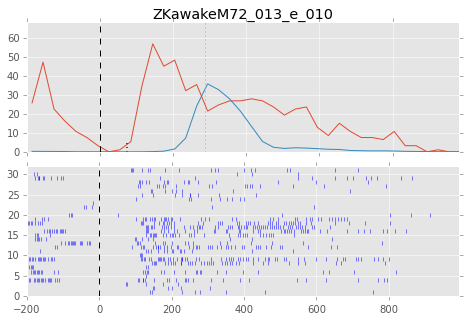

In [16]:
stim = all_odors['2-hydroxy_high']
print stim.responses.keys()
warp = True
[r.get_response_onset(warped=warp, bin_size=30, p_ks=0.01) for r in list(stim.responses.values()[:])]
[r.plot(warped=warp, bin_size=30) for r in list(stim.responses.values()[:])]
print r.response_onset

['ZKawakeM72_013_e_011', 'ZKawakeM72_013_e_010']


[{'ax_stack': <matplotlib.figure.AxesStack at 0x7fc9d947da90>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7fc9d8a825d0>},
 {'ax_stack': <matplotlib.figure.AxesStack at 0x7fc9d9b4ff90>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7fc9d9a02e50>}]

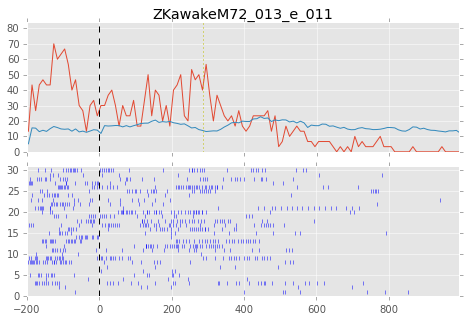

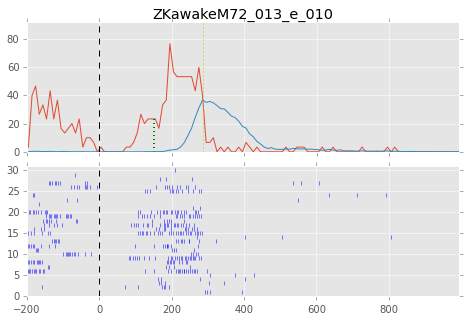

In [8]:
stim = all_odors['menthone_med']
print stim.responses.keys()
warp = True
[r.get_response_onset(warped=warp) for r in list(stim.responses.values())]
[r.plot(warped=warp) for r in list(stim.responses.values())]

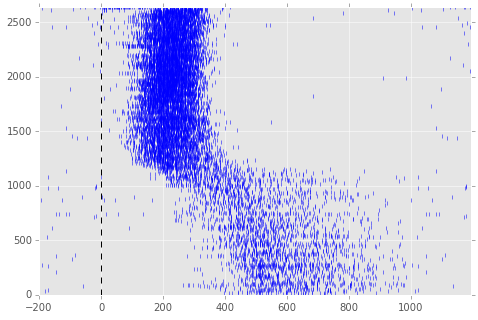

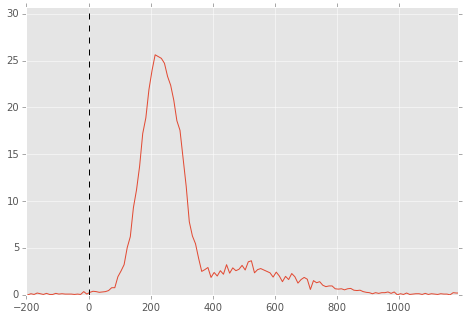

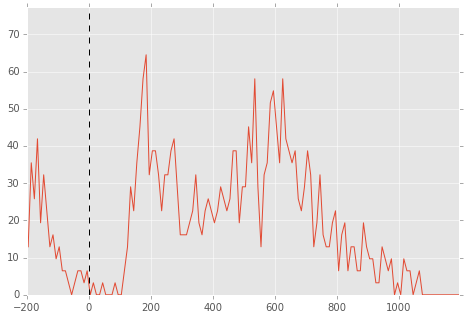

In [83]:
rec_name = 'ZKawakeM72_013_f_010'
r0=st_1.responses[rec_name]
rst = r0.make_raster(warped=True)
#plot_raster(rst, t0=200)
#plot_raster(rst, bin_size=10, t0=200)
bl=r0.baseline.make_raster(t_pre=0, t_post=1394, warped=True)
plot_raster(bl, t0=200)
plot_raster(bl, t0=200, bin_size=10)
plot_raster(rst, t0=200, bin_size=10)
bin_size = 10
events   = bl.shape[0]
t_stamps = bl.shape[1]
t=np.arange(t_stamps)-200
t_dec = decim(t, bin_size)



In [3]:
def count_spikes(response):
    all_sniffs = np.sort(response.baseline.sniff_data, order=['inh_len', 't_0'])
    inh_len, exh_len = get_warping_parameters(all_sniffs, means=False)
    t_post = inh_len + exh_len

    rst_sp = response.make_raster(t_pre=0, t_post=t_post, warped=True).mean(axis=0)
    bl_sp = response.baseline.make_raster(t_pre=0, t_post=t_post, warped=True).mean(axis=0)
    
    extra = rst_sp - bl_sp
    
    inh_spikes = extra[0: inh_len].sum()/(inh_len*0.001)
    exh_spikes = extra[inh_len: t_post].sum()/(inh_len*0.001)
    
    return inh_spikes, exh_spikes



    

In [102]:
#list the cells in a path
def list_cells(cells_path):
    all_cells = [f for f in os.listdir(cells_path) if os.path.isfile(os.path.join(cells_path,f)) ]
    all_units = [f[0:-9] for f in all_cells if f.find('cell.mat')>0]
    return all_units

# get all units that have records, and get the corresponding trials, baselines and baseline sniffs.
def load_cells(cells_path='', cells_list = None):
    """
    :param cells_path: folder with the exportable matlab files. default is taken from fn.fold_exp_data
    :return: records (list of all the records of all the cells)
    """
    
    if cells_list is None:
        all_cells = [f for f in os.listdir(cells_path) if os.path.isfile(os.path.join(cells_path,f)) ]
        unit_files = [f for f in all_cells if f.find('cell.mat')>0]
    else:
        all_cells = [f + '_cell.mat' for f in cells_list]

    responses  = {} # the rasters and stim sets of every unit recorded

    #rec related dictionaries
    rec_trials = {} # the trial structures of every rec instance
    baselines  = {} # the baselines of every cell; keys of dict are record[i]['meta']['id']
    base_sniff = {} # the sniff baselines
    #dictionary of rec related data to load
    #'key' : [dict of the loaded data, 'tail of the filenames', loading function]
    rec_data = {'rec_trials' : [rec_trials, '_trial.mat', load_trials],
                'base_sniff' : [base_sniff, '_noStimSniff.mat', load_sniffs],
                }

    #unit related dictionaries
    unit_spikes = {} # the trial structures of every rec instance
    #dictionary of unit related data to load
    unit_data = {'units' : [unit_spikes, '_spikes.mat', load_unit]}

    i_f = 0
    for unit_file in unit_files:
        i_f+=1
        rec_file = os.path.join(cells_path,unit_file)
        #print unit_file
        unit_recs = load_cell(rec_file, as_dict = True)
        responses.update(unit_recs)
        #get the baselines for those recs
        base_path = os.path.join(cells_path, unit_recs.itervalues().next()['meta']['u_id'] + '_spikesBase.mat')
        #print base_path
        rec_bases = load_baseline(base_path)
        print rec_bases.keys()
        baselines.update(rec_bases)

        for a_key in unit_data.keys():
            load_function  = unit_data[a_key][2]
            load_name_tail = unit_data[a_key][1]
            load_dict      = unit_data[a_key][0]

            paths = [os.path.join(cells_path, unit_recs[a_rec]['meta']['id'] + load_name_tail) \
                     for a_rec in unit_recs]
            #[load_dict.update(load_function(a_path)) for a_path in paths]
        #the recording belongs to a cell (cellId)
        #TODO: get the cell (for cell signature; i.e: auto_correlogram)

        #for rec in unit_recs:
        #that recording has trials and sniffs associated.
        #get them, if they have not already been gotten
        for a_key in rec_data.keys():

            load_function  = rec_data[a_key][2]
            load_name_tail = rec_data[a_key][1]
            load_dict      = rec_data[a_key][0]

            paths = [os.path.join(cells_path, a_rec['rec_id'] + load_name_tail) \
                     for a_rec in unit_recs.itervalues() if a_rec['rec_id'] not in load_dict]
            #print paths
            [load_dict.update(load_function(a_path)) for a_path in paths]

    records = {'responses':  responses,
               'baselines':  baselines,
               'trials':     rec_trials,
               'base_sniff': base_sniff}
    return records

uf = list_cells(cells_path)
all_cells = [f + '_cell.mat' for f in uf if f.find('KPawakeM72_019')>-1]
print all_cells
newrecs=load_cells(cells_path, all_cells)

['KPawakeM72_019_002_cell.mat', 'KPawakeM72_019_003_cell.mat', 'KPawakeM72_019_004_cell.mat', 'KPawakeM72_019_005_cell.mat', 'KPawakeM72_019_006_cell.mat', 'KPawakeM72_019_007_cell.mat', 'KPawakeM72_019_010_cell.mat', 'KPawakeM72_019_011_cell.mat', 'KPawakeM72_019_013_cell.mat', 'KPawakeM72_019_014_cell.mat', 'KPawakeM72_019_015_cell.mat', 'KPawakeM72_019_018_cell.mat', 'KPawakeM72_019_020_cell.mat', 'KPawakeM72_019_021_cell.mat']


NameError: global name 'load_trials' is not defined

In [99]:
uf[1].find('KPawakeM72_019')>-1

False

In [7]:
all_odors

{'2-hydroxy_high': <analysis.stimulus.Stimulus instance at 0x7f0d67362b90>}

In [3]:
def digit_to_char(digit):
    if digit < 10:
        return str(digit)
    return chr(ord('a') + digit - 10)

def str_base(number, base):
    assert(number >= 0 and base > 1)
    (d, m) = divmod(number, base)
    if d > 0:
        return str_base(d, base) + digit_to_char(m)
    return digit_to_char(m)

def is_palindrome(string):
    l_s = len(string)
    
    if l_s == 1:
        return True
    else:
        return string[-(len(string)//2):][::-1] == string[:(len(string)//2)]
        
def min_base_for_palindrome(n):
    assert(n>=0 and n<=1000)
    is_pal = False
    base = 1
    while not is_pal:
        base +=1
        is_pal = is_palindrome(str_base(n, base))
    
    return base

str_base(0,3)

'0'

In [31]:
string = str_base(0,2)
print string
print string[-(len(string)//2):]
string[-(len(string)//2):][::-1] == string[:(len(string)//2)]
is_palindrome(string)

0
0


True

In [12]:
number = 17
base =  min_base_for_palindrome(number)
print base
print str_base(number, base)

2
10001
